In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

#### Load the Dataset

In [ ]:
# Load the dataset
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\Source_Capstone_Data.xlsx"
df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized

#### Data Preprocessing

In [15]:
# Drop unnecessary columns
columns_to_drop = [
    "D.[NamePostfix]", "F.[Name]", "G1.[ParameterID]", "G1.[Name]", "G1.[OperatorMessage]", 
    "G2.[ParameterID]", "G2.[Name]", "G2.[Description]", "G3.[ParameterID]", "G3.[Name]", 
    "G3.[OperatorMessage]", "A.[ParameterID]", "A.[EntryTimestamp]", "A.[DataValue]", 
    "A.[Description]", "B.[ParameterID]", "B.[EntryTimestamp]", "B.[DataValue]", 
    "B.[Description]", "C.[ParameterID]"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Convert measurement values to numeric
df['C.[DataValue]'] = pd.to_numeric(df['C.[DataValue]'], errors='coerce')

# Convert timestamps to datetime and sort
df['C.[EntryTimestamp]'] = pd.to_datetime(df['C.[EntryTimestamp]'], errors='coerce')
df = df.dropna(subset=['C.[EntryTimestamp]']).sort_values(by='C.[EntryTimestamp]').reset_index(drop=True)

# Outlier Removal Using IQR
Q1 = df["C.[DataValue]"].quantile(0.25)
Q3 = df["C.[DataValue]"].quantile(0.75)
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["C.[DataValue]"] >= lower_bound) & (df["C.[DataValue]"] <= upper_bound)].reset_index(drop=True)

# Create Lag Features
for lag in [1, 2, 3, 5]:
    df[f"DataValue_Lag{lag}"] = df["C.[DataValue]"].shift(lag)

# Create Rolling Statistics
df["Rolling_Mean_3"] = df["C.[DataValue]"].rolling(window=3).mean()
df["Rolling_Std_3"] = df["C.[DataValue]"].rolling(window=3).std()
df["Rolling_Mean_5"] = df["C.[DataValue]"].rolling(window=5).mean()
df["Rolling_Std_5"] = df["C.[DataValue]"].rolling(window=5).std()

# Drop rows with NaN values (due to shifting)
df = df.dropna().reset_index(drop=True)

# Create a Cycle Count
df["Cycle_Count"] = range(1, len(df) + 1)

#### Train Model

In [16]:
# Define feature columns (Removing low-importance features: DataValue_Lag1, DataValue_Lag2)
feature_columns = [
    "Cycle_Count", "C.[DataValue]", "DataValue_Lag3", "DataValue_Lag5",
    "Rolling_Mean_3", "Rolling_Std_3", "Rolling_Mean_5", "Rolling_Std_5"
]

# Define target variable and drop last row to avoid NaN target
df["Target_NextCycle"] = df["C.[DataValue]"].shift(-1)
df = df.dropna().reset_index(drop=True)

# Split data into training and testing sets (80% train, 20% test)
X = df[feature_columns]
y = df["Target_NextCycle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor with reduced complexity
model = RandomForestRegressor(
    n_estimators=40,        # Reduce trees further to limit memorization
    max_depth=5,            # Shallower trees to reduce overfitting
    min_samples_split=15,    # Require at least 15 samples to split an internal node
    min_samples_leaf=7,       # Require at least 7 samples at each leaf node
    max_features="sqrt",     # Consider a subset of features per split
    bootstrap=True,          # Helps prevent model from memorizing training data
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=15, n_estimators=40, random_state=42)

#### Model Evaluation

Model Evaluation Metrics (Test Set):
Mean Absolute Error (MAE): 0.0147
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0202
R-squared (R²): 0.2723


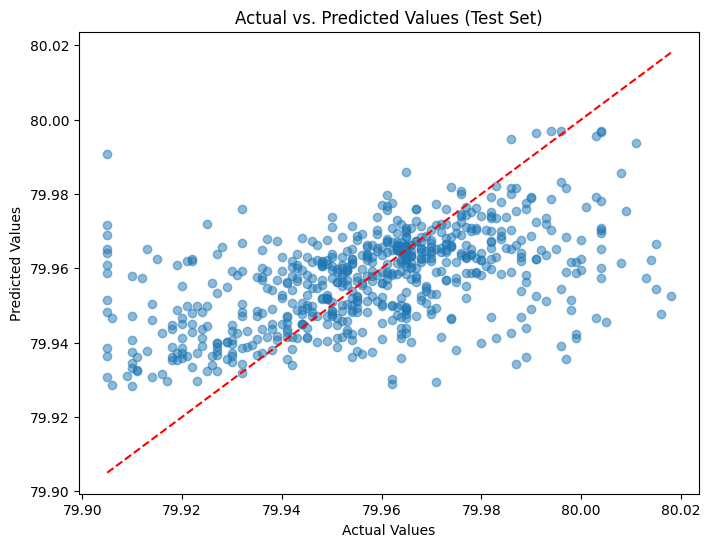

In [17]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Model Evaluation Metrics (Test Set):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot actual vs. predicted values for the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # 45-degree line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Test Set)")
plt.show()



#### Predict Future Wear

In [21]:
# Define how many future cycles to predict
future_cycles = 10  # Adjust as needed

# Create a DataFrame for future predictions
future_df = pd.DataFrame()
future_df["Cycle_Count"] = range(df["Cycle_Count"].max() + 1, df["Cycle_Count"].max() + 1 + future_cycles)

# Use the last known values as the starting point for predictions
last_known_values = df.iloc[-1][feature_columns].to_dict()
predicted_bores = []

# Predict future bore sizes using the trained regression model
for cycle in future_df["Cycle_Count"]:
    new_row = last_known_values.copy()
    new_row["Cycle_Count"] = cycle

    # Shift lag values forward
    for lag in [1, 2, 3, 5]:
        new_row[f"DataValue_Lag{lag}"] = predicted_bores[-lag] if len(predicted_bores) >= lag else last_known_values["C.[DataValue]"]

    # Update rolling statistics dynamically
    new_row["Rolling_Mean_3"] = np.mean(predicted_bores[-3:]) if len(predicted_bores) >= 3 else last_known_values["Rolling_Mean_3"]
    new_row["Rolling_Std_3"] = np.std(predicted_bores[-3:]) if len(predicted_bores) >= 3 else last_known_values["Rolling_Std_3"]
    new_row["Rolling_Mean_5"] = np.mean(predicted_bores[-5:]) if len(predicted_bores) >= 5 else last_known_values["Rolling_Mean_5"]
    new_row["Rolling_Std_5"] = np.std(predicted_bores[-5:]) if len(predicted_bores) >= 5 else last_known_values["Rolling_Std_5"]

    # Convert to DataFrame and predict bore size
    new_X = pd.DataFrame([new_row])[feature_columns]
    predicted_bore = model.predict(new_X)[0]
    predicted_bores.append(predicted_bore)

    # Store new row values for further processing
    future_df.loc[future_df["Cycle_Count"] == cycle, "Predicted_Bore_Size"] = predicted_bore

# Compute bore size changes over time
future_df["Bore_Size_Change"] = future_df["Predicted_Bore_Size"].diff().fillna(0)

# Define wear classification function
def classify_wear(change):
    if change < 0.001:                    # Adjust as needed
        return "Normal Wear" 
    elif 0.001 <= change < 0.005:         # Adjust as needed
        return "Moderate Wear"
    else:
        return "Critical Wear"

# Assign wear labels to future cycles
future_df["Predicted_Wear_Stage"] = future_df["Bore_Size_Change"].apply(classify_wear)

#### Finalized Dataset

In [19]:
# Combine actual & future data
df["Predicted_Bore_Size"] = np.nan  # Set actual cycles to NaN in prediction column
df["Predicted_Wear_Stage"] = np.nan

# Final dataset
final_df = pd.concat([df, future_df], ignore_index=True)

# Save predicted dataset 
output_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\rfr_future_wear_predictions.xlsx"
final_df.to_excel(output_path, index=False, engine='openpyxl')

final_df

,D.[AssemblyName],C.[EntryTimestamp],C.[DataValue],C.[MinValue],C.[MaxValue],DataValue_Lag1,DataValue_Lag2,DataValue_Lag3,DataValue_Lag5,Rolling_Mean_3,Rolling_Std_3,Rolling_Mean_5,Rolling_Std_5,Cycle_Count,Target_NextCycle,Predicted_Bore_Size,Predicted_Wear_Stage,Bore_Size_Change
0,D0445091,2022-03-02 13:22:24.463,79.984,79.905,80.025,79.910,79.910,79.950,80.00,79.934667,0.042724,79.9508,0.041391,1,79.984,NaN,NaN,NaN
1,D0445091,2022-03-02 13:22:24.463,79.984,79.905,80.025,79.984,79.910,79.910,80.00,79.959333,0.042724,79.9476,0.037024,2,79.945,NaN,NaN,NaN
2,D0449996,2022-03-02 14:15:29.987,79.945,79.905,80.025,79.984,79.984,79.910,79.95,79.971000,0.022517,79.9466,0.037011,3,79.920,NaN,NaN,NaN
3,D0445074,2022-03-03 06:07:59.953,79.920,79.905,80.025,79.945,79.984,79.984,79.91,79.949667,0.032254,79.9486,0.034739,4,79.940,NaN,NaN,NaN
4,D0445102,2022-03-03 07:24:16.150,79.940,79.905,80.025,79.920,79.945,79.984,79.91,79.935000,0.013229,79.9546,0.028422,5,79.952,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3247,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3248,NaN,79.995587,Normal Wear,-0.000829
3248,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3249,NaN,79.994947,Normal Wear,-0.000639
3249,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3250,NaN,79.994588,Normal Wear,-0.000359
3250,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3251,NaN,79.994151,Normal Wear,-0.000437
